In [319]:
import numpy as np
import pandas as pd
import os, datetime
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [3]:
test = pd.read_csv('../data/data-2018/2018-01-01.csv')
data_dirs = ['../data/atc18/']
model_name = 'ST4000DM000'
all_features = list(test.loc[test['model'] == model_name].dropna(axis=1, how='all').columns.values)
def process(df, name):
    df = df.loc[df['model'] == name]
    return df[all_features]
type_dict = {feature: np.float32 for feature in all_features[5:]}
model = pd.concat([process(pd.read_csv(os.path.join(data_dir, filename), dtype=type_dict), model_name) for data_dir in data_dirs for filename in os.listdir(data_dir)])
model_dropped = model.dropna(axis='columns', how='all').drop(['model', 'capacity_bytes', 'failure'], axis='columns').sort_values(by='date', ascending=True)

In [140]:
model_dropped = model_dropped[[c for c in model_dropped.columns if c.lower()[-10:] != 'normalized']]
err_names = model_dropped.loc[model_dropped['smart_5_raw'] > 0]['serial_number'].unique()
err_names

array(['Z3011RDM', 'Z3025RLA', 'Z3014BW4', 'Z30056BA', 'Z3025KPZ',
       'W300BNKB', 'Z3012X9J', 'Z304JHWK', 'Z304JWPG', 'Z300K0PL',
       'Z305KVMN', 'Z3025LLE', 'W300BZEQ', 'Z300WKJ9', 'Z302511G',
       'Z300ZSKJ', 'Z300V5RQ', 'S300YSL6', 'Z305TDEN', 'Z301570R',
       'S301N8DJ', 'Z305D5V7', 'Z300JE88', 'Z304KCCQ', 'Z30149VM',
       'Z304HZQA', 'Z303GGET', 'Z303Z7QT', 'Z300MW5G', 'S300YC5D',
       'Z300XEBY', 'Z305GXYQ', 'Z300XCKR', 'Z300P8XS', 'Z300WQJW',
       'Z305DH7P', 'Z304JW0M', 'W300BVRK', 'S30107GG', 'Z3058P3G',
       'Z305D4XN', 'S300ZRYS', 'Z300GQF8', 'W300BBDL', 'Z304PDKE',
       'Z3059YMB', 'Z302AKX9', 'S300YQF1', 'Z3010V8X', 'Z3024W0K',
       'Z3051XFQ', 'Z3044ZL9', 'Z305DH06', 'Z300GQ50', 'Z3025WBK',
       'Z3035QGV', 'Z300E448', 'Z30561XX', 'Z304JA3E', 'Z305GVS4',
       'Z300GZ84', 'Z3014QG6', 'S301NG7A', 'Z3025M6M', 'Z304HSSW',
       'Z305GL2B', 'Z300W64Q', 'Z305CX1N', 'Z304KBNL', 'W300BN1L',
       'Z300XEFF', 'Z300W0XD', 'S300ABFR', 'Z305CTFS', 'S300Z5

In [175]:
err_disks = model_dropped.loc[model_dropped['serial_number'].isin(err_names)].reset_index(drop=True)
before_err = err_disks.loc[err_disks['smart_5_raw'] == 0]
before_err.shape

(3487, 26)

In [216]:
grouped = before_err.groupby(['serial_number'], as_index=False)
features = [c for c in before_err.columns if c[-3:] == 'raw']
# get the difference of the data of a window with size 3
diff = grouped[features].transform(pd.DataFrame.diff, 3)

# get variance of the data of a window with size 7
sigma = grouped[features].transform(lambda x: x.rolling(7).var())

# get the sum of attribute valuse within a window with size 5
summation = grouped[features].transform(lambda x: x.rolling(5).sum())

# add the transformed data to the attributes
dataset = before_err.copy()
dataset = dataset.join(other=diff, how='inner', rsuffix='_diff')
dataset = dataset.join(other=sigma, how='inner', rsuffix='_sigma')
dataset = dataset.join(other=summation, how='inner', rsuffix='_sum')
dataset.shape
dataset = dataset.dropna().sort_values(by=['date'], ascending=True).reset_index(drop=True)
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['broken_day'] = dataset.groupby('serial_number')['date'].transform(lambda x: x.max())
dataset['y'] = dataset['broken_day']  - dataset['date'] + datetime.timedelta(days=1)

dataset.to_csv('./preprocess/dataset.csv')
dataset.head()

,date,serial_number,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_12_raw,...,smart_193_raw_sum,smart_194_raw_sum,smart_197_raw_sum,smart_198_raw_sum,smart_199_raw_sum,smart_240_raw_sum,smart_241_raw_sum,smart_242_raw_sum,broken_day,y
0,2017-10-07,Z30427BT,367920.0,0.0,9.0,0.0,899242304.0,18148.0,0.0,9.0,...,108110.0,142.0,0.0,0.0,0.0,89913.0,1.116318e+11,8.625685e+11,2017-11-30,55 days
1,2017-10-07,Z3015GTC,225721344.0,0.0,12.0,0.0,601222592.0,28226.0,0.0,12.0,...,192875.0,132.0,0.0,0.0,0.0,140110.0,1.192434e+11,7.740114e+11,2017-11-22,47 days
2,2017-10-07,Z3059KPY,84057136.0,0.0,6.0,0.0,440060224.0,16180.0,0.0,5.0,...,949069.0,95.0,80.0,80.0,0.0,75516.0,1.173629e+11,2.182675e+11,2017-11-19,44 days
3,2017-10-07,Z307STTY,98514288.0,0.0,4.0,0.0,18237500.0,1413.0,0.0,4.0,...,236205.0,155.0,0.0,0.0,0.0,5928.0,3.985225e+10,1.519400e+10,2017-10-27,21 days
4,2017-10-07,Z3029GV9,205300000.0,0.0,8.0,0.0,33200312.0,23741.0,0.0,8.0,...,62995.0,103.0,160.0,160.0,0.0,118138.0,1.199221e+11,1.006969e+12,2017-12-10,65 days


In [274]:
def get_result(y_test, y_pred, threshold):
    pred = [1 if i < threshold else 0 for i in y_pred]
    true = [1 if i < threshold else 0 for i in y_test]
    return (true, pred)

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return(TP, FP, TN, FN)

In [317]:
training_set = dataset.loc[dataset['broken_day'].astype(str) < '2017-12-01'].copy()
testing_set = dataset.loc[(dataset['broken_day'].astype(str) >= '2017-12-01') & (dataset['date'].astype(str) >= '2017-12-01')].copy()    
all_features = [c for c in training_set.columns if c[:5] == 'smart']
removed_features = []

y_train = training_set['y'].dt.days
y_test = testing_set['y'].dt.days
X_train = training_set[all_features].astype(np.float32)
X_test = testing_set[all_features].astype(np.float32)
    
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)

uni_threshold = 20
true, pred = get_result(y_test, y_pred, uni_threshold)
max_f1 = f1_score(true, pred)

for i in all_features: 
    selected_features = [c for c in all_features if c not in removed_features and c != i]
    X_train = training_set[selected_features].astype(np.float32)
    X_test = testing_set[selected_features].astype(np.float32)
    gbr_model = GradientBoostingRegressor()
    gbr_model.fit(X_train, y_train)
    y_pred = gbr_model.predict(X_test)
    true, pred = get_result(y_test, y_pred, uni_threshold)
    f1 = f1_score(true, pred)
    if f1 > max_f1:
        max_f1 = f1
        removed_features.append(i)
print(max_f1)

selected_features = [c for c in all_features if c not in removed_features]
X_train = training_set[selected_features].astype(np.float32)
X_test = testing_set[selected_features].astype(np.float32)
# normalization and truly fit
X_train_norm = (X_train - X_train.mean()).values
X_test_norm = (X_test - X_test.mean()).values
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_norm, y_train)
y_pred = gbr_model.predict(X_test_norm)

0.8661157024793389


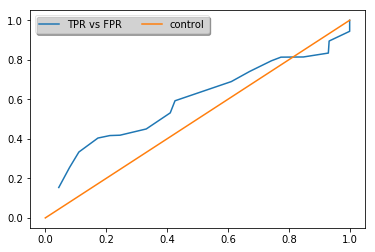

In [318]:
y_TPR = []
x_FPR = []
for thre in range(0, 90):
    true, pred = get_result(y_test, y_pred, thre)
    TP, FP, TN, FN = perf_measure(true, pred)
    if TP+FN == 0 or FP + TN == 0:
        continue
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    y_TPR.append(TPR)
    x_FPR.append(FPR)

ax = plt.subplot(111)

plt.plot(x_FPR, y_TPR, label="TPR vs FPR")
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), label="control")
# t1 = np.arange(0.0, 1.0, 0.01)
# for n in [1, 2, 3, 4]:

leg = plt.legend(loc='best', ncol=2, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.show()

In [315]:
print(removed_features)

['smart_1_raw', 'smart_10_raw', 'smart_187_raw', 'smart_189_raw', 'smart_190_raw', 'smart_242_raw']


In [316]:
print(x_FPR)
print(y_TPR)
# 0.12, 0.29

[0.029498525073746312, 0.04777070063694268, 0.12758620689655173, 0.16165413533834586, 0.20816326530612245, 0.25892857142857145, 0.28780487804878047, 0.34210526315789475, 0.39204545454545453, 0.5555555555555556, 0.6040268456375839, 0.6691176470588235, 0.6854838709677419, 0.7678571428571429, 0.79, 0.8651685393258427, 0.9240506329113924, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.11538461538461539, 0.17647058823529413, 0.29333333333333333, 0.41414141414141414, 0.4083333333333333, 0.41843971631205673, 0.43125, 0.4742857142857143, 0.5291005291005291, 0.5763546798029556, 0.6481481481481481, 0.74235807860262, 0.7593360995850622, 0.782608695652174, 0.8113207547169812, 0.8840579710144928, 0.8951048951048951, 0.9491525423728814, 0.9703947368421053, 0.9871794871794872, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


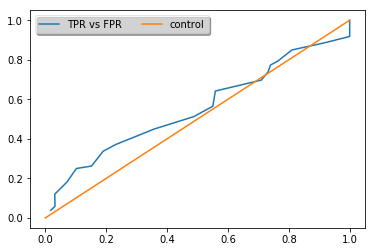

In [336]:
training_set = dataset.loc[dataset['broken_day'].astype(str) < '2017-12-01'].copy()
testing_set = dataset.loc[(dataset['broken_day'].astype(str) >= '2017-12-01') & (dataset['date'].astype(str) >= '2017-12-01')].copy()    
all_features = [c for c in training_set.columns if c[:5] == 'smart']

y_train = training_set['y'].dt.days
y_test = testing_set['y'].dt.days
X_train = training_set[all_features].astype(np.float32)
X_test = testing_set[all_features].astype(np.float32)

rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
importances = rfg.feature_importances_

selected_features = [all_features[i] for i in np.argwhere(importances>0.01).reshape((-1,))]
X_train = training_set[selected_features].astype(np.float32)
X_test = testing_set[selected_features].astype(np.float32)
# normalization and truly fit
X_train_norm = (X_train - X_train.mean()).values
X_test_norm = (X_test - X_test.mean()).values
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_norm, y_train)
y_pred = gbr_model.predict(X_test_norm)

y_TPR = []
x_FPR = []
for thre in range(0, 90):
    true, pred = get_result(y_test, y_pred, thre)
    TP, FP, TN, FN = perf_measure(true, pred)
    if TP+FN == 0 or FP + TN == 0:
        continue
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    y_TPR.append(TPR)
    x_FPR.append(FPR)

ax = plt.subplot(111)

plt.plot(x_FPR, y_TPR, label="TPR vs FPR")
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), label="control")
# t1 = np.arange(0.0, 1.0, 0.01)
# for n in [1, 2, 3, 4]:

leg = plt.legend(loc='best', ncol=2, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.show()

In [337]:
print(x_FPR)
print(y_TPR)
# 0.102, 0.25

[0.017699115044247787, 0.03184713375796178, 0.03103448275862069, 0.07142857142857142, 0.10204081632653061, 0.15178571428571427, 0.1902439024390244, 0.23157894736842105, 0.35795454545454547, 0.4876543209876543, 0.5503355704697986, 0.5588235294117647, 0.7096774193548387, 0.7321428571428571, 0.74, 0.7640449438202247, 0.810126582278481, 0.9142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.038461538461538464, 0.058823529411764705, 0.12, 0.18181818181818182, 0.25, 0.2624113475177305, 0.3375, 0.37142857142857144, 0.4497354497354497, 0.5123152709359606, 0.5648148148148148, 0.6419213973799127, 0.6970954356846473, 0.7391304347826086, 0.7735849056603774, 0.7934782608695652, 0.8496503496503497, 0.8847457627118644, 0.9177631578947368, 0.9871794871794872, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [355]:
from sklearn.feature_selection import chi2

training_set = dataset.loc[dataset['broken_day'].astype(str) < '2017-12-01'].copy()
testing_set = dataset.loc[(dataset['broken_day'].astype(str) >= '2017-12-01') & (dataset['date'].astype(str) >= '2017-12-01')].copy()    
all_features = [c for c in training_set.columns if c[:5] == 'smart']

y_train = training_set['y'].dt.days
y_test = testing_set['y'].dt.days
X_train = training_set[all_features].astype(np.float32)
X_test = testing_set[all_features].astype(np.float32)

chi2s, p_valures = chi2(X_train - X_train.min(), y_train)
selected_features = [all_features[i] for i in list(np.argsort(chi2s))[-30:]]
X_train = training_set[selected_features].astype(np.float32)
X_test = testing_set[selected_features].astype(np.float32)

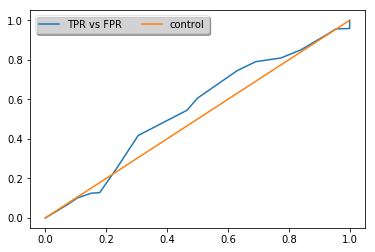

In [356]:
# normalization and truly fit
X_train_norm = (X_train - X_train.mean())
X_test_norm = (X_test - X_test.mean())
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_norm, y_train)
y_pred = gbr_model.predict(X_test_norm)

y_TPR = []
x_FPR = []
for thre in range(0, 90):
    true, pred = get_result(y_test, y_pred, thre)
    TP, FP, TN, FN = perf_measure(true, pred)
    if TP+FN == 0 or FP + TN == 0:
        continue
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    y_TPR.append(TPR)
    x_FPR.append(FPR)

ax = plt.subplot(111)

plt.plot(x_FPR, y_TPR, label="TPR vs FPR")
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), label="control")
# t1 = np.arange(0.0, 1.0, 0.01)
# for n in [1, 2, 3, 4]:

leg = plt.legend(loc='best', ncol=2, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.show()

In [357]:
print(x_FPR)
print(y_TPR)
# 0.105, 0.101

[0.0, 0.0, 0.07241379310344828, 0.10526315789473684, 0.1510204081632653, 0.17857142857142858, 0.23414634146341465, 0.30526315789473685, 0.4659090909090909, 0.5, 0.6308724832214765, 0.6911764705882353, 0.7741935483870968, 0.8392857142857143, 0.93, 0.9550561797752809, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.06666666666666667, 0.10101010101010101, 0.125, 0.1276595744680851, 0.25, 0.41714285714285715, 0.544973544973545, 0.6059113300492611, 0.7453703703703703, 0.7903930131004366, 0.8091286307053942, 0.849802371541502, 0.9320754716981132, 0.9565217391304348, 0.958041958041958, 0.9593220338983051, 0.9605263157894737, 0.9839743589743589, 0.996875, 0.9969512195121951, 0.9970149253731343, 0.9970760233918129, 0.9971264367816092, 0.9971671388101983, 1.0, 1.0]


In [360]:
from sklearn.feature_selection import mutual_info_classif
training_set = dataset.loc[dataset['broken_day'].astype(str) < '2017-12-01'].copy()
testing_set = dataset.loc[(dataset['broken_day'].astype(str) >= '2017-12-01') & (dataset['date'].astype(str) >= '2017-12-01')].copy()    
all_features = [c for c in training_set.columns if c[:5] == 'smart']

y_train = training_set['y'].dt.days
y_test = testing_set['y'].dt.days
X_train = training_set[all_features].astype(np.float32)
X_test = testing_set[all_features].astype(np.float32)
importances = mutual_info_classif(X_train, y_train)
selected_features = [all_features[i] for i in np.argwhere(importances>0.01).reshape((-1,))]
X_train = training_set[selected_features].astype(np.float32)
X_test = testing_set[selected_features].astype(np.float32)

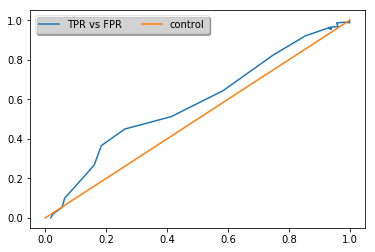

In [361]:
# normalization and truly fit
X_train_norm = (X_train - X_train.mean())
X_test_norm = (X_test - X_test.mean())
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_norm, y_train)
y_pred = gbr_model.predict(X_test_norm)

y_TPR = []
x_FPR = []
for thre in range(0, 90):
    true, pred = get_result(y_test, y_pred, thre)
    TP, FP, TN, FN = perf_measure(true, pred)
    if TP+FN == 0 or FP + TN == 0:
        continue
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    y_TPR.append(TPR)
    x_FPR.append(FPR)

ax = plt.subplot(111)

plt.plot(x_FPR, y_TPR, label="TPR vs FPR")
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), label="control")
# t1 = np.arange(0.0, 1.0, 0.01)
# for n in [1, 2, 3, 4]:

leg = plt.legend(loc='best', ncol=2, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.show()

In [362]:
print(x_FPR)
print(y_TPR)
# 0.129, 0.212

[0.017699115044247787, 0.025477707006369428, 0.05517241379310345, 0.06390977443609022, 0.07346938775510205, 0.12946428571428573, 0.16097560975609757, 0.18421052631578946, 0.26136363636363635, 0.41358024691358025, 0.5838926174496645, 0.75, 0.8548387096774194, 0.9285714285714286, 0.94, 0.9325842696629213, 0.9620253164556962, 0.9571428571428572, 0.9836065573770492, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0196078431372549, 0.05333333333333334, 0.10101010101010101, 0.11666666666666667, 0.2127659574468085, 0.26875, 0.3657142857142857, 0.4497354497354497, 0.5123152709359606, 0.6435185185185185, 0.8253275109170306, 0.921161825726141, 0.9604743083003953, 0.9547169811320755, 0.9637681159420289, 0.9685314685314685, 0.9864406779661017, 0.9901315789473685, 0.9871794871794872, 0.990625, 0.9908536585365854, 0.9970149253731343, 0.9970760233918129, 1.0, 1.0, 1.0, 1.0]


[Text(0,0,'Proposed'),
 Text(0,0,'RF'),
 Text(0,0,'Chi2'),
 Text(0,0,'Mutual Info')]

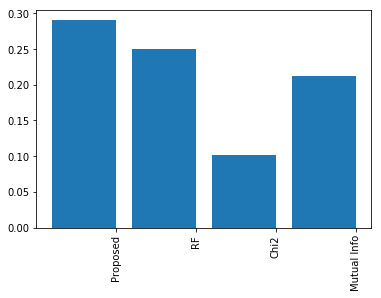

In [366]:
fig = plt.figure()
ax = plt.subplot(111)
width=0.8
values = [0.29, 0.25, 0.101, 0.212]
labels = ['Proposed', 'RF', 'Chi2', 'Mutual Info']
ax.bar(range(len(values)), values, width=width)
ax.set_xticks(np.arange(len(values)) + width/2)
ax.set_xticklabels(labels, rotation=90)

In [367]:
training_set = dataset.loc[dataset['broken_day'].astype(str) < '2017-12-01'].copy()
testing_set = dataset.loc[(dataset['broken_day'].astype(str) >= '2017-12-01') & (dataset['date'].astype(str) >= '2017-12-01')].copy()    
all_features = [c for c in training_set.columns if c[:5] == 'smart']
removed_features = []

y_train = training_set['y'].dt.days
y_test = testing_set['y'].dt.days
X_train = training_set[all_features].astype(np.float32)
X_test = testing_set[all_features].astype(np.float32)
    
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)

uni_threshold = 20
true, pred = get_result(y_test, y_pred, uni_threshold)
max_f1 = f1_score(true, pred)

for i in all_features: 
    selected_features = [c for c in all_features if c not in removed_features and c != i]
    X_train = training_set[selected_features].astype(np.float32)
    X_test = testing_set[selected_features].astype(np.float32)
    gbr_model = GradientBoostingRegressor()
    gbr_model.fit(X_train, y_train)
    y_pred = gbr_model.predict(X_test)
    true, pred = get_result(y_test, y_pred, uni_threshold)
    f1 = f1_score(true, pred)
    if f1 > max_f1:
        max_f1 = f1
        removed_features.append(i)
print(max_f1)

selected_features = [c for c in all_features if c not in removed_features]
X_train = training_set[selected_features].astype(np.float32)
X_test = testing_set[selected_features].astype(np.float32)
# normalization and truly fit
X_train_norm = (X_train - X_train.mean()).values
X_test_norm = (X_test - X_test.mean()).values

0.8642384105960264


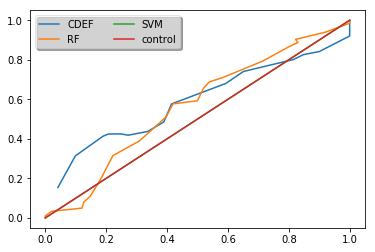

In [372]:
from sklearn.svm import SVR


ax = plt.subplot(111)

# break
y_TPR = [] 
x_FPR = []
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_norm, y_train)
y_pred = gbr_model.predict(X_test_norm)
for thre in range(0, 90):
    true, pred = get_result(y_test, y_pred, thre)
    TP, FP, TN, FN = perf_measure(true, pred)
    if TP+FN == 0 or FP + TN == 0:
        continue
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    y_TPR.append(TPR)
    x_FPR.append(FPR)
plt.plot(x_FPR, y_TPR, label='CDEF')

# break
y_TPR = [] 
x_FPR = []
rf_model = RandomForestRegressor()
rf_model.fit(X_train_norm, y_train)
y_pred = rf_model.predict(X_test_norm)
for thre in range(0, 90):
    true, pred = get_result(y_test, y_pred, thre)
    TP, FP, TN, FN = perf_measure(true, pred)
    if TP+FN == 0 or FP + TN == 0:
        continue
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    y_TPR.append(TPR)
    x_FPR.append(FPR)
plt.plot(x_FPR, y_TPR, label='RF')

# break
y_TPR = [] 
x_FPR = []
SVR_model = SVR()
SVR_model.fit(X_train_norm, y_train)
y_pred = SVR_model.predict(X_test_norm)
for thre in range(0, 90):
    true, pred = get_result(y_test, y_pred, thre)
    TP, FP, TN, FN = perf_measure(true, pred)
    if TP+FN == 0 or FP + TN == 0:
        continue
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    y_TPR.append(TPR)
    x_FPR.append(FPR)
plt.plot(x_FPR, y_TPR, label='SVM')

plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), label="control")
# t1 = np.arange(0.0, 1.0, 0.01)
# for n in [1, 2, 3, 4]:

leg = plt.legend(loc='best', ncol=2, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.show()